# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2021

## Project 3 - Triangular mesh generator

Due Friday, April 2

First we include some libraries and define utility functions from the lecture notes:

In [1]:
using PyPlot, LinearAlgebra, PyCall

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

function delaunay(p)
    # Delaunay triangulation `t` of array of nodes `p`
    tri = pyimport("matplotlib.tri")
    t = tri[:Triangulation](first.(p), last.(p))
    t = Int64.(t[:triangles] .+ 1)
    t = [ t[i,:] for i = 1:size(t,1) ]
end

delaunay (generic function with 1 method)

### Description

In this project you will write an unstructured triangular mesh generator based on the Delaunay refinement algorithm. The steps will be described in detail, and for testing we will use the following simple polygon:

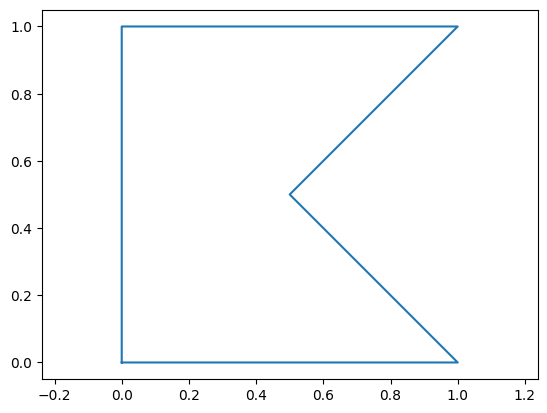

In [2]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

### Problem 1 - Point in polygon

Write a function `inpolygon(p, pv)` which determines if a point `p` is inside the closed polygon `pv`. For example, in the test polygon above, the point $(0.6,0.3)$ is inside but $(0.8,0.3)$ is outside. For the algorithm, use the "Crossing number method" as described here: <http://geomalgorithms.com/a03-_inclusion.html>.

In [3]:
function inpolygon(p, pv)
    
    n = length(pv) # length of nodes
    intersections = 0 # keep track of intersections
    
    # check for each node of pv
    for i = 1:n-1
        
        # either it passes rule 1 or it passes rule 2
        if ((pv[i][2] <= p[2]) && (pv[i+1][2] > p[2])) ||  
            ((pv[i][2] > p[2]) && (pv[i+1][2] <= p[2]))
            
            # store the value of y intersect of Edge[i]
            val = Float64(p[2] - pv[i][2])/(pv[i+1][2] - pv[i][2])
            
            # check to see if the p.x is less than x intersect of Edge[i]
            if (p[1] ≤ pv[i][1] + (val * (pv[i+1][1] - pv[i][1])))
                
                # increase the intersection 
                intersections += 1
                
            end

        end

    end

    # return true if (intersection) is odd, return false if positive
    # odd meaning it is inside, and positive if its outside
    return intersections % 2 == 1

end


inpolygon (generic function with 1 method)

### Problem 2 - Triangle properties

Next we need functions for computing some basic quantities from triangles. Here, a triangle `tri` is represented as an array of 3 points, e.g.

In [4]:
tri = [[1,0.5], [2,1], [0,3]]

3-element Array{Array{Float64,1},1}:
 [1.0, 0.5]
 [2.0, 1.0]
 [0.0, 3.0]

### Problem 2(a) - Triangle area

Write a function `tri_area(tri)` which returns the area of `tri`.

In [5]:
function tri_area(tri)
    
    
    Ax = tri[1][1] # x point of the first coordinate
    Bx = tri[2][1] # x point of the second coordiate
    Cx = tri[3][1] # x point of the third coordinate
    Ay = tri[1][2] # y point of the first coordinate
    By = tri[2][2] # y point of the second coordinte
    Cy = tri[3][2] # y point of the third coodinate 
    
    # value of the area; refrence: https://www.mathopenref.com/coordtrianglearea.html
    area = abs(Ax * (By - Cy) + Bx * (Cy - Ay) + Cx * (Ay - By))/2
        
    return(area)
end

tri_area (generic function with 1 method)

### Problem 2(b) - Triangle centroid

Write a function `tri_centroid(tri)` which returns the centroid of `tri` (<https://en.wikipedia.org/wiki/Centroid#Of_a_triangle>).

In [6]:
function tri_centroid(tri)

    xcoord = (1/3) * sum(first.(tri)) # 1/3 times the sum of the x coordinates of three points
    ycoord = (1/3) * sum(last.(tri)) # 1/3 times the sum of the y coordinates of three points
    
    # return a tuple in the form of Array{Float64,1}
    return [xcoord,ycoord] 
    
end

tri_centroid (generic function with 1 method)

### Problem 2(c) - Triangle circumcenter

Write a function `tri_circumcenter(tri)` which returns the circumcenter of `tri` (<https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates_2>).

In [7]:
function tri_circumcenter(tri)

    Ax = tri[1][1] # x point of the first coordinate
    Bx = tri[2][1] # x point of the second coordiate
    Cx = tri[3][1] # x point of the third coordinate
    Ay = tri[1][2] # y point of the first coordinate
    By = tri[2][2] # y point of the second coordinte
    Cy = tri[3][2] # y point of the third coodinate 
    
    D = 2 * (Ax * (By - Cy) + Bx * (Cy - Ay) + Cx * (Ay - By))
    
    # x and y cooridnate of the point for cicumcenter
    ux = (1/D) * ((Ax^2 + Ay^2)*(By - Cy) + (Bx^2 + By^2)*(Cy - Ay) + (Cx^2 + Cy^2)*(Ay - By))
    uy = (1/D) * ((Ax^2 + Ay^2)*(Cx - Bx) + (Bx^2 + By^2)*(Ax - Cx) + (Cx^2 + Cy^2)*(Bx - Ax))
    
    return [ux, uy]
    
end

tri_circumcenter (generic function with 1 method)


### Problem 3 - Mesh generator

Write a function with the syntax `p,t = pmesh(pv, hmax)` which generates a mesh `p,t` of the polygon `pv`, with triangle side lengths approximately `hmax`. Follow the algorithm as described below.

(a) The input `pv` is an array of points which defines the polygon. Note that the last point is equal to the first (a closed polygon).

(b) First, create node points `p` along each polygon segment, separated by a distance approximately equal to `hmax`. Make sure not to duplicate any nodes.

(c) Triangulate the domain using the `delaunay` function.

(d) Remove the triangles outside the polygon, by computing all the triangle centroids (using `tri_centroid`) and determining if they are inside (using `inpolygon`).

(e) Find the triangle with largest area $A$ (using `tri_area`). If $A > h_\mathrm{max}^2/2 $, add the circumcenter of the triangle to the list of node points `p`.

(f) Repeat steps (c)-(d), that is, re-triangulate and remove outside triangles.

(g) Repeat steps (e)-(f) until no triangle area $A > h_\mathrm{max}^2/2$.

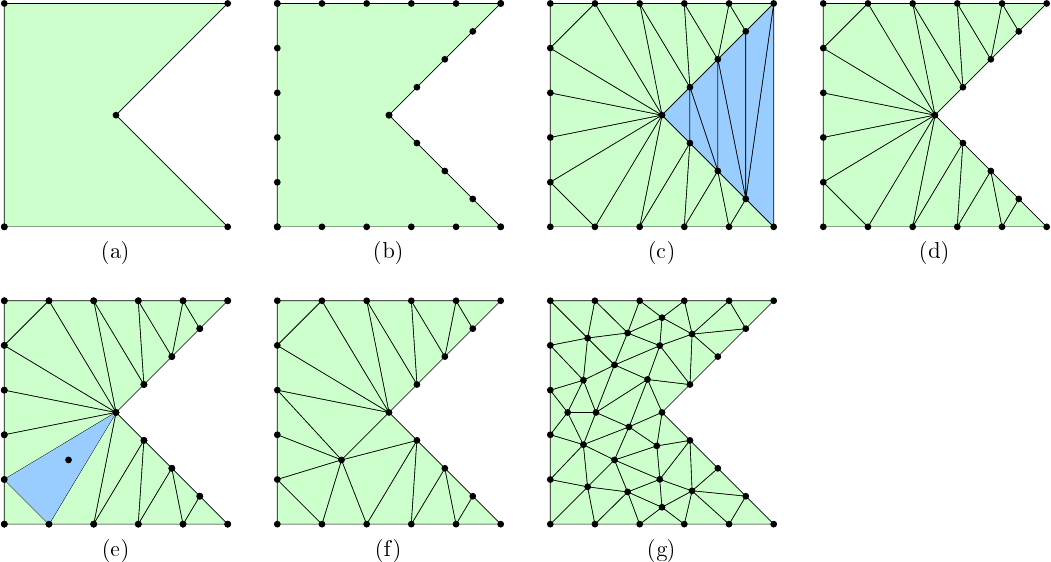

In [8]:
function pmesh(pv, hmax)
    
    p = [] # init an empty list to store the nodes
    
    # iterate as many as there are points provided in pv
    for elem = 1:length(pv)-1
        
        # for each iteration, define the x and y coords for the initial point of the segment
        x = pv[elem][1]
        y = pv[elem][2]
        push!(p,[x, y]) # add it to the nodes
        
        # compute the number of the partition the segment is supposed to be partitioned into 
        # define the x and y increment which is added to the x and y coord
        hdist = ceil(sqrt((pv[elem+1][1] - pv[elem][1])^2 + (pv[elem+1][2] - pv[elem][2])^2)/hmax)
        Δx = (pv[elem+1][1] - pv[elem][1])/hdist
        Δy = (pv[elem+1][2] - pv[elem][2])/hdist
        
        # we add the newly obtained points on the partitioned segment
        for j = 1:hdist-1
            x += Δx
            y += Δy
            push!(p,[x, y])
        end
        
    end
    
    t = delaunay(p) # obtain the coordinates for the triangulation using the nodes

    # repeat this process 
    # as long as the triangle with the most area is larger than (hmax)^2/2
    while true
        
        # to filter out from the triangulaton the triangles outside of polygon
        # to do so iterate through each element of triangulation
        # compute the centroid and check to see if its outside/inside of polygon
        keptInd = []
        for arr in t
            
            i = arr[1] # index of the first node
            ii = arr[2] # index of the second node
            iii = arr[3] # index of the third node
            
            # array of arrays for the three coordinates representing a triangle
            triangle = [p[i], p[ii], p[iii]] 
            cent = tri_centroid(triangle)
            
            if inpolygon(tri_centroid(triangle), pv)
                # add the index of the triangulation element to be kept from t
                index = (findfirst(isequal(arr), t))
                push!(keptInd, index)
            end 
            
        end
        
        # only keep the triangulation that are valid
        t = t[keptInd,:1]
        
        max_area = 0 # keep track of the triangle with the largest area
        areaCoord= [] # coordinates of the largest triangle
        
        # iterate through the triangulation 
        for arr in t
            
            i = arr[1] # index of the first node
            ii = arr[2] # index of the second node
            iii = arr[3] # index of the third node
            triangle = [p[i], p[ii], p[iii]] 
            Area = tri_area(triangle) # area of the triangle
            
            # if area is larger than the largest triangle thus far
            # update the value of the area
            # update the coordinate values
            if Area > max_area
                
                max_area = Area
                areaCoord = triangle
                
            end
        end
        
        # if max area is larger than ((hmax^2)/2)) we add the circumcenter to nodes
        if (max_area > ((hmax^2)/2))
            circum = tri_circumcenter(areaCoord)
            push!(p,circum)  
        end
        
        # if eventually the triangle with max area becomes less than ((hmax^2)/2)) we break out
        if (max_area < ((hmax^2)/2))
            break
        end 
        
        t = delaunay(p) # update the triangulation after each iteration
        
    end
    
    return p,t # return nodes and triangualtion coordinates
end

pmesh (generic function with 1 method)

### Test cases

Run the cases below to test your mesh generator.

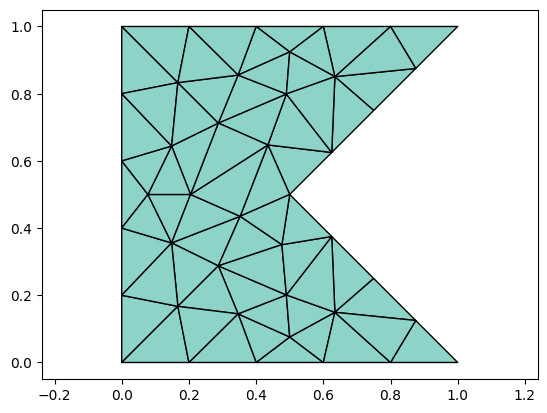

In [9]:
# The polygon in the examples
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p,t = pmesh(pv, 0.2)
tplot(p,t)

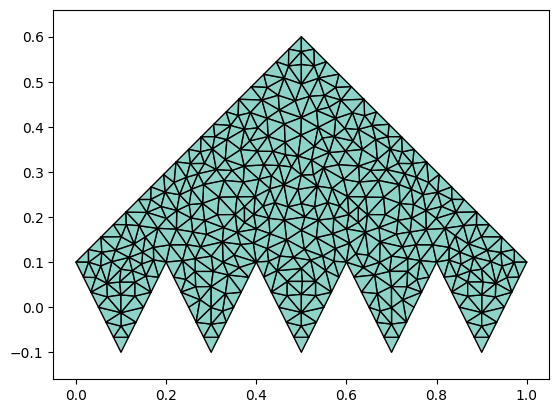

In [10]:
# A more complex shape
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
p,t = pmesh(pv, 0.04)
tplot(p,t)